In [ ]:
import os

print("Current directory:", os.getcwd())

# Set working directory to project root
os.chdir('/mnt/workspace/tvae')
print("Changed to:", os.getcwd())

Directorio actual: /mnt/workspace/tvae/notebooks
Cambiado a: /mnt/workspace/tvae


In [ ]:
# Cell 1 — verify environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

print("pandas :", pd.__version__)
print("numpy  :", np.__version__)

# Verify access to filtered parquet
f = pq.ParquetFile('raw_data/metabonet_train_filtered.parquet')
print(f"\nFiltered parquet:")
print(f"  Rows      : {f.metadata.num_rows:,}")
print(f"  Columns   : {f.metadata.num_columns}")
print(f"  Row groups: {f.metadata.num_row_groups}")
print(f"  Schema    : {[f.schema_arrow.field(i).name for i in range(f.metadata.num_columns)]}")

pandas : 2.2.3
numpy  : 1.26.4

Parquet filtrado:
  Filas     : 121,388,404
  Columnas  : 12
  Row groups: 249
  Schema    : ['id', 'date', 'CGM', 'bolus', 'basal', 'carbs', 'insulin', 'heartrate', 'age', 'gender', 'age_of_diagnosis', 'insulin_delivery_modality']


In [ ]:
# Cell 2 — global statistics in streaming mode
import pyarrow.parquet as pq
from collections import defaultdict

f = pq.ParquetFile('raw_data/metabonet_train_filtered.parquet')

# Accumulators
stats = {
    'total_rows'   : 0,
    'patients'     : set(),
    'cgm_count'    : 0,
    'cgm_missing'  : 0,
    'cgm_sum'      : 0.0,
    'cgm_sum_sq'   : 0.0,
    'cgm_min'      : float('inf'),
    'cgm_max'      : float('-inf'),
    'bolus_events' : 0,
    'carbs_events' : 0,
    'basal_events' : 0,
}

# CGM histogram (5 mg/dL bins between 40 and 400)
cgm_bins  = np.zeros(73, dtype=np.int64)
cgm_edges = np.linspace(40, 400, 74)

print("Processing chunks...")
for i, batch in enumerate(f.iter_batches(batch_size=1_000_000)):
    df = batch.to_pandas()
    
    stats['total_rows'] += len(df)
    stats['patients'].update(df['id'].unique())
    
    # CGM
    cgm = df['CGM'].dropna()
    cgm = cgm[cgm.between(40, 400)]
    stats['cgm_count']   += len(cgm)
    stats['cgm_missing'] += df['CGM'].isna().sum()
    stats['cgm_sum']     += cgm.sum()
    stats['cgm_sum_sq']  += (cgm**2).sum()
    stats['cgm_min']      = min(stats['cgm_min'], cgm.min() if len(cgm) > 0 else float('inf'))
    stats['cgm_max']      = max(stats['cgm_max'], cgm.max() if len(cgm) > 0 else float('-inf'))
    
    # CGM histogram
    counts, _ = np.histogram(cgm, bins=cgm_edges)
    cgm_bins += counts
    
    # Drivers
    stats['bolus_events'] += (df['bolus'] > 0).sum()
    stats['carbs_events'] += (df['carbs'] > 0).sum()
    stats['basal_events'] += (df['basal'] > 0).sum()
    
    if i % 20 == 0:
        print(f"  Chunk {i+1}/{f.metadata.num_row_groups}...")

# Compute mean and std
n   = stats['cgm_count']
mu  = stats['cgm_sum'] / n
std = np.sqrt(stats['cgm_sum_sq'] / n - mu**2)

print(f"\n{'─'*50}")
print(f"  Unique patients   : {len(stats['patients'])}")
print(f"  Total rows        : {stats['total_rows']:,}")
print(f"  CGM missing       : {stats['cgm_missing']:,} ({100*stats['cgm_missing']/stats['total_rows']:.1f}%)")
print(f"  CGM mean          : {mu:.1f} mg/dL")
print(f"  CGM std           : {std:.1f} mg/dL")
print(f"  CGM range         : [{stats['cgm_min']:.0f}, {stats['cgm_max']:.0f}]")
print(f"  Bolus events      : {stats['bolus_events']:,} ({100*stats['bolus_events']/stats['total_rows']:.1f}%)")
print(f"  Carbs events      : {stats['carbs_events']:,} ({100*stats['carbs_events']/stats['total_rows']:.1f}%)")
print(f"  Basal events      : {stats['basal_events']:,} ({100*stats['basal_events']/stats['total_rows']:.1f}%)")

Procesando chunks...
  Chunk 1/249...
  Chunk 21/249...
  Chunk 41/249...
  Chunk 61/249...
  Chunk 81/249...
  Chunk 101/249...
  Chunk 121/249...

──────────────────────────────────────────────────
  Pacientes únicos  : 831
  Total filas       : 121,388,404
  CGM missing       : 19,141,952 (15.8%)
  CGM media         : 147.5 mg/dL
  CGM std           : 59.0 mg/dL
  CGM rango         : [40, 400]
  Eventos bolus     : 6,104,079 (5.0%)
  Eventos carbs     : 1,421,727 (1.2%)
  Eventos basal     : 80,641,736 (66.4%)


In [ ]:
# Cell 3 — per-patient analysis in streaming mode
f = pq.ParquetFile('raw_data/metabonet_train_filtered.parquet')

patient_stats = defaultdict(lambda: {
    'rows': 0, 'cgm_missing': 0,
    'bolus_events': 0, 'carb_events': 0,
    'date_min': None, 'date_max': None
})

for i, batch in enumerate(f.iter_batches(batch_size=1_000_000)):
    df = batch.to_pandas()
    df['date'] = pd.to_datetime(df['date'])
    
    for pid, grp in df.groupby('id'):
        p = patient_stats[pid]
        p['rows']         += len(grp)
        p['cgm_missing']  += grp['CGM'].isna().sum()
        p['bolus_events'] += (grp['bolus'] > 0).sum()
        p['carb_events']  += (grp['carbs'] > 0).sum()
        
        dmin = grp['date'].min()
        dmax = grp['date'].max()
        p['date_min'] = dmin if p['date_min'] is None else min(p['date_min'], dmin)
        p['date_max'] = dmax if p['date_max'] is None else max(p['date_max'], dmax)

    if i % 20 == 0:
        print(f"  Chunk {i+1}/249...")

# Convert to DataFrame
rows = []
for pid, p in patient_stats.items():
    duration_days = (p['date_max'] - p['date_min']).days if p['date_min'] else 0
    rows.append({
        'id'            : pid,
        'records'       : p['rows'],
        'duration_days' : duration_days,
        'cgm_missing_pct': 100 * p['cgm_missing'] / p['rows'],
        'bolus_events'  : p['bolus_events'],
        'carb_events'   : p['carb_events'],
    })

df_patients = pd.DataFrame(rows)

print(f"\n{'─'*50}")
print(f"  Records per patient:")
print(f"    Mean    : {df_patients['records'].mean():,.0f}  (~{df_patients['records'].mean()/288:.0f} days)")
print(f"    Median  : {df_patients['records'].median():,.0f}  (~{df_patients['records'].median()/288:.0f} days)")
print(f"    Min     : {df_patients['records'].min():,}")
print(f"    Max     : {df_patients['records'].max():,}")

print(f"\n  Actual duration (days):")
print(f"    Mean    : {df_patients['duration_days'].mean():.0f}")
print(f"    Median  : {df_patients['duration_days'].median():.0f}")
print(f"    >30 days: {(df_patients['duration_days'] > 30).sum()} patients")
print(f"    >90 days: {(df_patients['duration_days'] > 90).sum()} patients")
print(f"    >180 days: {(df_patients['duration_days'] > 180).sum()} patients")

print(f"\n  Patients with sufficient windows:")
for w, l in [(288,'24h'), (1008,'3.5d'), (2016,'1week')]:
    n = (df_patients['records'] >= w).sum()
    print(f"    >={w} records ({l}): {n} patients ({100*n/len(df_patients):.0f}%)")

print(f"\n  CGM missing per patient:")
print(f"    Median missing% : {df_patients['cgm_missing_pct'].median():.1f}%")
print(f"    >20% missing    : {(df_patients['cgm_missing_pct'] > 20).sum()} patients")

  Chunk 1/249...
  Chunk 21/249...
  Chunk 41/249...
  Chunk 61/249...
  Chunk 81/249...
  Chunk 101/249...
  Chunk 121/249...

──────────────────────────────────────────────────
  Registros por paciente:
    Media   : 146,075  (~507 días)
    Mediana : 121,853  (~423 días)
    Min     : 8,747
    Max     : 616,747

  Duración real (días):
    Media   : 780
    Mediana : 425
    >30 días: 830 pacientes
    >90 días: 821 pacientes
    >180 días: 780 pacientes

  Pacientes con ventanas suficientes:
    >=288 registros (24h): 831 pacientes (100%)
    >=1008 registros (3.5d): 831 pacientes (100%)
    >=2016 registros (1sem): 831 pacientes (100%)

  CGM missing por paciente:
    Mediana missing% : 8.9%
    >20% missing     : 219 pacientes


In [ ]:
# Cell 4 — relation bolus + basal vs insulin
f = pq.ParquetFile('raw_data/metabonet_train_filtered.parquet')

# Read only first chunk for inspection
batch = next(f.iter_batches(
    columns=['bolus','basal','insulin'],
    batch_size=1_000_000
))
df = batch.to_pandas()

# Filter rows where insulin > 0
mask = df['insulin'] > 0
sample = df[mask].copy()
sample['bolus_plus_basal'] = sample['bolus'].fillna(0) + sample['basal'].fillna(0)

diff = (sample['bolus_plus_basal'] - sample['insulin']).abs()
match_exact = (diff < 0.001).mean() * 100
match_close = (diff < 0.1).mean() * 100
corr = sample['bolus_plus_basal'].corr(sample['insulin'])

print(f"  Rows with insulin>0        : {len(sample):,}")
print(f"  Correlation                : {corr:.4f}")
print(f"  Exact match (<0.001)       : {match_exact:.1f}%")
print(f"  Approximate match (<0.1)   : {match_close:.1f}%")
print(f"\n  Sample values:")
print(sample[['bolus','basal','insulin','bolus_plus_basal']].head(10).to_string())

  Filas con insulin>0        : 360,065
  Correlación                : 0.6597
  Match exacto (<0.001)      : 41.5%
  Match aproximado (<0.1)    : 41.5%

  Muestra de valores:
      bolus     basal   insulin  bolus_plus_basal
3743    NaN  0.183333  0.183333          0.183333
3744    NaN  0.183333  0.183333          0.183333
3745    NaN  0.183333  0.183333          0.183333
3746    NaN  0.183333  0.183333          0.183333
3747    NaN  0.183333  0.183333          0.183333
3748    NaN  0.183333  0.183333          0.183333
3749    NaN  0.183333  0.183333          0.183333
3750    NaN  0.183333  0.183333          0.183333
3751    NaN  0.183333  0.183333          0.183333
3752    NaN  0.183333  0.183333          0.183333


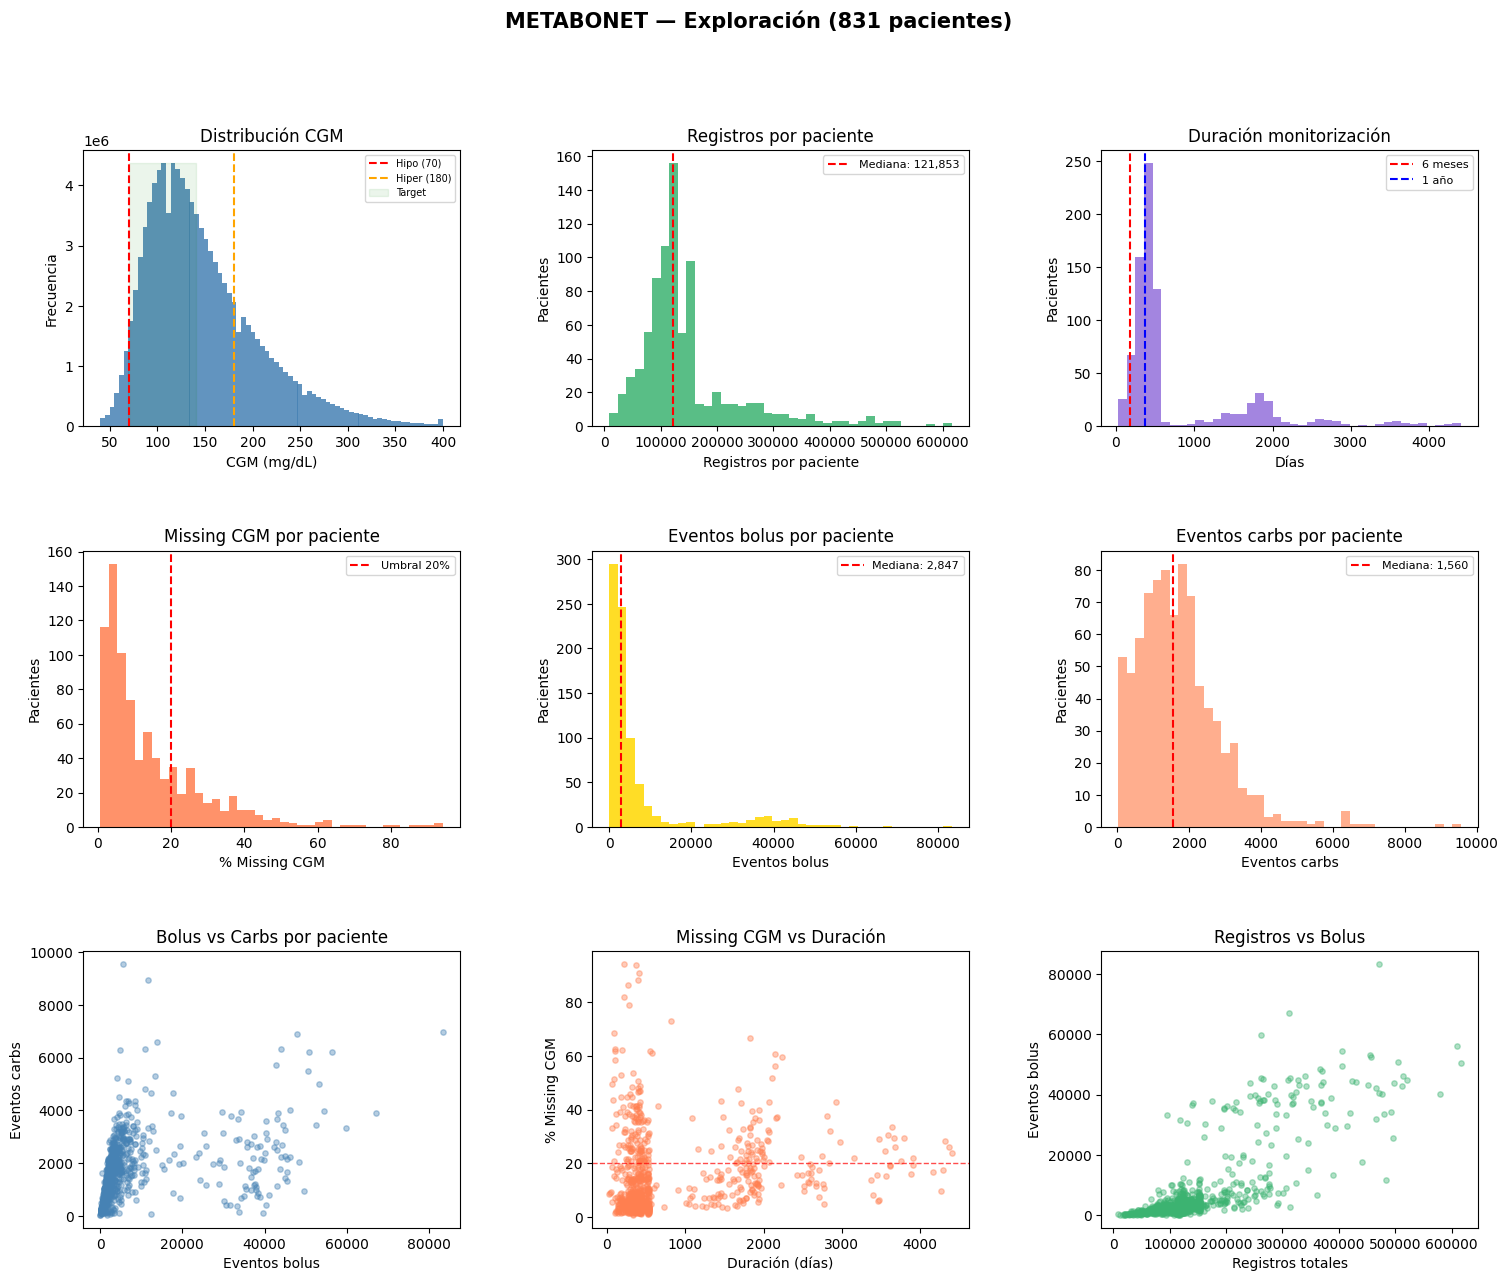

Guardado: plots/01_exploration.png


In [ ]:
# Cell 5 — distribution plots
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

fig = plt.figure(figsize=(18, 14))
fig.suptitle("METABONET — Exploration (831 patients)", fontsize=15, fontweight='bold')
gs = gridspec.GridSpec(3, 3, figure=fig, hspace=0.45, wspace=0.35)

# ── 1: CGM distribution (using accumulated histogram from cell 2) ──
ax = fig.add_subplot(gs[0, 0])
centers = (cgm_edges[:-1] + cgm_edges[1:]) / 2
ax.bar(centers, cgm_bins, width=5, color='steelblue', alpha=0.85, edgecolor='none')
ax.axvline(70,  color='red',    linestyle='--', lw=1.5, label='Hypo (70)')
ax.axvline(180, color='orange', linestyle='--', lw=1.5, label='Hyper (180)')
ax.fill_betweenx([0, cgm_bins.max()], 70, 140, alpha=0.08, color='green', label='Target')
ax.set_xlabel('CGM (mg/dL)')
ax.set_ylabel('Frequency')
ax.set_title('CGM distribution')
ax.legend(fontsize=7)

# ── 2: Records per patient ──
ax = fig.add_subplot(gs[0, 1])
ax.hist(df_patients['records'], bins=40, color='mediumseagreen', alpha=0.85, edgecolor='none')
ax.axvline(df_patients['records'].median(), color='red', linestyle='--', lw=1.5,
           label=f"Median: {df_patients['records'].median():,.0f}")
ax.set_xlabel('Records per patient')
ax.set_ylabel('Patients')
ax.set_title('Records per patient')
ax.legend(fontsize=8)

# ── 3: Duration in days ──
ax = fig.add_subplot(gs[0, 2])
ax.hist(df_patients['duration_days'], bins=40, color='mediumpurple', alpha=0.85, edgecolor='none')
ax.axvline(180, color='red',  linestyle='--', lw=1.5, label='6 months')
ax.axvline(365, color='blue', linestyle='--', lw=1.5, label='1 year')
ax.set_xlabel('Days')
ax.set_ylabel('Patients')
ax.set_title('Monitoring duration')
ax.legend(fontsize=8)

# ── 4: Missing CGM per patient ──
ax = fig.add_subplot(gs[1, 0])
ax.hist(df_patients['cgm_missing_pct'], bins=40, color='coral', alpha=0.85, edgecolor='none')
ax.axvline(20, color='red', linestyle='--', lw=1.5, label='20% threshold')
ax.set_xlabel('% Missing CGM')
ax.set_ylabel('Patients')
ax.set_title('Missing CGM per patient')
ax.legend(fontsize=8)

# ── 5: Bolus events per patient ──
ax = fig.add_subplot(gs[1, 1])
ax.hist(df_patients['bolus_events'], bins=40, color='gold', alpha=0.85, edgecolor='none')
ax.axvline(df_patients['bolus_events'].median(), color='red', linestyle='--', lw=1.5,
           label=f"Median: {df_patients['bolus_events'].median():,.0f}")
ax.set_xlabel('Bolus events')
ax.set_ylabel('Patients')
ax.set_title('Bolus events per patient')
ax.legend(fontsize=8)

# ── 6: Carbs events per patient ──
ax = fig.add_subplot(gs[1, 2])
ax.hist(df_patients['carb_events'], bins=40, color='lightsalmon', alpha=0.85, edgecolor='none')
ax.axvline(df_patients['carb_events'].median(), color='red', linestyle='--', lw=1.5,
           label=f"Median: {df_patients['carb_events'].median():,.0f}")
ax.set_xlabel('Carbs events')
ax.set_ylabel('Patients')
ax.set_title('Carbs events per patient')
ax.legend(fontsize=8)

# ── 7: Bolus vs Carbs scatter ──
ax = fig.add_subplot(gs[2, 0])
ax.scatter(df_patients['bolus_events'], df_patients['carb_events'],
           alpha=0.4, s=15, color='steelblue')
ax.set_xlabel('Bolus events')
ax.set_ylabel('Carbs events')
ax.set_title('Bolus vs Carbs per patient')

# ── 8: Missing CGM vs duration ──
ax = fig.add_subplot(gs[2, 1])
ax.scatter(df_patients['duration_days'], df_patients['cgm_missing_pct'],
           alpha=0.4, s=15, color='coral')
ax.axhline(20, color='red', linestyle='--', lw=1, alpha=0.7)
ax.set_xlabel('Duration (days)')
ax.set_ylabel('% Missing CGM')
ax.set_title('Missing CGM vs Duration')

# ── 9: Records vs bolus events ──
ax = fig.add_subplot(gs[2, 2])
ax.scatter(df_patients['records'], df_patients['bolus_events'],
           alpha=0.4, s=15, color='mediumseagreen')
ax.set_xlabel('Total records')
ax.set_ylabel('Bolus events')
ax.set_title('Records vs Bolus')

plt.savefig('plots/01_exploration.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: plots/01_exploration.png")

In [ ]:
# Cell 6 — CGM profile of example patients
f = pq.ParquetFile('raw_data/metabonet_train_filtered.parquet')

# Pick patient with most records
best_pid = df_patients.loc[df_patients['records'].idxmax(), 'id']
median_pid = df_patients.iloc[(df_patients['records'] - df_patients['records'].median()).abs().argsort()[:1]]['id'].values[0]

patient_data = {best_pid: [], median_pid: []}

for batch in f.iter_batches(columns=['id', 'date', 'CGM', 'bolus', 'carbs', 'basal'],
                              batch_size=1_000_000):
    df = batch.to_pandas()
    for pid in [best_pid, median_pid]:
        chunk = df[df['id'] == pid]
        if len(chunk) > 0:
            patient_data[pid].append(chunk)

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
fig.suptitle("CGM Profile — Example Patients", fontsize=14, fontweight='bold')

titles = {best_pid: f"Patient {best_pid} (most data)", 
          median_pid: f"Patient {median_pid} (median data)"}

for ax, pid in zip(axes, [best_pid, median_pid]):
    df_p = pd.concat(patient_data[pid]).sort_values('date')
    
    # Show only 30 days for clarity
    df_p = df_p.head(30 * 288)
    
    ax.plot(df_p['date'], df_p['CGM'], 
            color='steelblue', lw=0.6, alpha=0.9, label='CGM')
    ax.fill_between(df_p['date'], 70, 140,
                    alpha=0.1, color='green', label='Target range')
    ax.axhline(70,  color='red',    linestyle='--', lw=1, alpha=0.7)
    ax.axhline(180, color='orange', linestyle='--', lw=1, alpha=0.7)
    
    # Mark bolus events
    bolus_mask = df_p['bolus'] > 0
    ax.scatter(df_p.loc[bolus_mask, 'date'], 
               df_p.loc[bolus_mask, 'CGM'],
               color='red', s=8, alpha=0.6, label='Bolus', zorder=5)
    
    # Mark carb events
    carb_mask = df_p['carbs'] > 0
    ax.scatter(df_p.loc[carb_mask, 'date'],
               df_p.loc[carb_mask, 'CGM'],
               color='gold', s=8, alpha=0.6, label='Carbs', zorder=5)
    
    ax.set_ylabel('CGM (mg/dL)')
    ax.set_title(titles[pid])
    ax.legend(fontsize=8, loc='upper right')
    ax.tick_params(axis='x', rotation=30, labelsize=7)
    ax.set_ylim(30, 420)

plt.tight_layout()
plt.savefig('plots/02_cgm_profiles.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: plots/02_cgm_profiles.png")